# Autoencoder (sparse)
--- 

In this notebook we will train a sparse fully connected (dense) autoencoder on the nasa data set.

The keras code was inspired by https://blog.keras.io/building-autoencoders-in-keras.html

In [4]:
# inports
import numpy as np

import keras
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import TensorBoard

from util import plot_spectrogram_features
from util import plot_reconstruction_error
from util import load_data
from util import scale

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [5]:
import tensorflow as tf
print(tf.__version__)
keras.__version__

2.6.0


'2.6.0'

In [6]:
# auxiliary variable
tensorboard_path = "./"

## Load NASA data

In [7]:
path = "./features_nasa.pickle"
X_train, X_test = load_data(path)

---

## Build Model

In [8]:
# input dim
n_features = X_train.shape[1] 
# number of hidden units
encoding_dim = 2*n_features

print("Number of features:", n_features)
print("Number of hidden units:", encoding_dim)

Number of features: 100
Number of hidden units: 200


In [9]:
# Create model
model = Sequential()
model.add(Dense(input_shape=(n_features,), units=encoding_dim, activation='sigmoid', activity_regularizer=regularizers.l1(0.001)))
# now the model will take as input arrays of shape (*, n_features)
# and output arrays of shape (*, encoding_dim)
# uppdate: reguralization term in the loss function
model.add(Dense(units=n_features, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
Total params: 40,300
Trainable params: 40,300
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Optimizer stochastic gradient descent
sgd = optimizers.SGD(learning_rate=0.2, decay=1e-6, momentum=0.9, nesterov=True)

In [13]:
# Compile model
model.compile(optimizer=sgd, loss='mean_squared_error')

### Prepare data

In [14]:
# Normalization (choose one sensor)
nb_sensor = 0
x_train = scale(X_train[:,:,nb_sensor])
x_test = scale(X_test[:,:,nb_sensor], samples=x_train.shape[0])

print("Shape of traing set scaled: \t {}".format(x_train.shape))
print("Shape of test set scaled: \t {}".format(x_test.shape))

Shape of traing set scaled: 	 (246, 100)
Shape of test set scaled: 	 (984, 100)


In [15]:
### Train Model

In [16]:
x_train.shape

(246, 100)

In [17]:
# Fit the model
model.fit(x_train, x_train,
                epochs=50,
                batch_size=20,
                shuffle=True,
                callbacks=[TensorBoard(log_dir=tensorboard_path)])

Epoch 1/50
13/13 [==============================] - 1s 90ms/step - loss: 1.2919
Epoch 2/50
13/13 [==============================] - 0s 2ms/step - loss: 1.1243
Epoch 3/50
13/13 [==============================] - 0s 2ms/step - loss: 1.1046
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 1.1005
Epoch 5/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0979
Epoch 6/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0955
Epoch 7/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0930
Epoch 8/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0903
Epoch 9/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0877
Epoch 10/50
13/13 [==============================] - 0s 2ms/step - loss: 1.0849
Epoch 11/50
13/13 [==============================] - 0s 3ms/step - loss: 1.0821
Epoch 12/50
13/13 [==============================] - 0s 4ms/step - loss: 1.0791
Epoch 13/50
13/13 [=============================

### Reconstruction Error

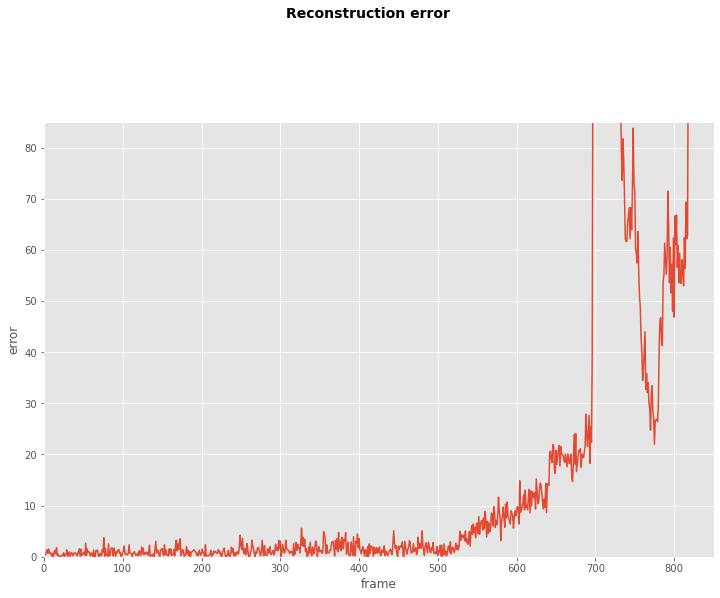

In [18]:
# evaluate the model
# calculate the reconstruction error
costs = np.zeros(x_test.shape[0])
for i, x in enumerate(x_test):
    input_x = np.reshape(x, (1, x_test.shape[1]))
    reconstruction = model.predict(input_x)
    # calculate mean squared error
    costs[i] = ((x - reconstruction[0]) ** 2).mean(axis=0)

plot_reconstruction_error(scale(costs, samples=x_train.shape[0]))